# Lab 2 - Gradient Descent for Logistic Regression
## Pouya Khosravi
### Student Number: 500630934

## Dataset

A retrospective sample of males in a heart-disease high-risk region of the Western Cape,
South Africa is given.

This data is taken from a larger dataset, described in
Rousseauw et al, 1983, South African Medical Journal.

Below is a description of the variables:
1. sbp: systolic blood pressure
2. tobacco: cumulative tobacco (kg)
3. ldl: low densiity lipoprotein cholesterol
4. adiposity
5. famhist: family history of heart disease (Present, Absent)
6. typea: type-A behavior
7. obesity
8. alcohol: current alcohol consumption
9. age: age at onset
10. chd: coronary heart disease

## Goal

Our goal is predicting coronary heart disease which has two classes of 0 or 1 using Logistic
Regression based on all features (1 to 9).

## Setting Up Our Libraries 

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import random
import math
from sklearn.linear_model import LogisticRegression
import seaborn as sns

## Importing Our Dataset 

First we will import the dataset we will be working with so that we can modify the structure and cleaning it up for further processing

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/tofighi/MachineLearning/master/datasets/heart.csv')

In [3]:
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


First, we will use one-hot encoding for the catagorical variable 'famhist'. Next, we will drop the 'chd' and and 'row.names'

In [0]:
one_hot = pd.get_dummies(df['famhist'])               # get the one hot encoding of the family history column 
df.insert(1,'Absent',one_hot["Absent"])
df.insert(2,'Present',one_hot["Present"])

df_new = df.drop(['famhist','row.names','chd'], axis=1)                    # drop the family history catagorical column 

Since our goal is to predict coronary heart disease being either part of class 0 or class 1, we will use it as our y variable of our function 

Now we will insert our bias to our dataframe column, with all values of the column being 1

In [0]:


df_new.insert(0, column='Xo', value=1)


In [6]:
df_new.head()

,Xo,Absent,Present,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age
0,1,0,1,160,12.00,5.73,23.11,49,25.30,97.20,52
1,1,1,0,144,0.01,4.41,28.61,55,28.87,2.06,63
2,1,0,1,118,0.08,3.48,32.28,52,29.14,3.81,46
3,1,0,1,170,7.50,6.41,38.03,51,31.99,24.26,58
4,1,0,1,134,13.60,3.50,27.78,60,25.99,57.34,49


Now we will identify the different parts of our dataframe based on our goal. Since we are interested in the likelyhood of contracting coronary heart disease, we need to set this column as our output and the rest of the dataframe columns as our feature set of the dataset

In [7]:
y = df['chd']                                # label-set
X = df_new                                   # feature-set
                                    
X.head()

,Xo,Absent,Present,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age
0,1,0,1,160,12.00,5.73,23.11,49,25.30,97.20,52
1,1,1,0,144,0.01,4.41,28.61,55,28.87,2.06,63
2,1,0,1,118,0.08,3.48,32.28,52,29.14,3.81,46
3,1,0,1,170,7.50,6.41,38.03,51,31.99,24.26,58
4,1,0,1,134,13.60,3.50,27.78,60,25.99,57.34,49


## Standardization 
Now we want to normalize our dataset, to do this we will only normalize our non-catagorical variables and bias (i.e. the absent, present, and Xo columns)

In [0]:
for i in range(3, X.shape[1]):                    #taking the columns of the datframe after the 3rd column 
    avg = X.iloc[:,i].mean()                      #calculating the mean of X dataframe 
    sigma = X.iloc[:,i].std()                     #calculating the standard deviation of X dataframe 
    X.iloc[:,i] = (X.iloc[:,i] - avg) / sigma     #normalizing the X dataframe 

## Exploratory Data Analysis

#### What is the percentage of each class? (class 0 and class 1)?

In [9]:
total = y.value_counts(1)

print('Positive for chd:\t' + str(round(total[0]*100,1)) + '%')
print('Negative for chd:\t' + str(round(total[1]*100,1)) + '%')


Positive for chd:	65.4%
Negative for chd:	34.6%


#### How many missing values do we have?

In [10]:
print('\nMissing values:')
print(df.isnull().sum())


Missing values:
row.names    0
Absent       0
Present      0
sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64


Therefore, we can say with confidence that there are no missiing values from this dataset 

#### How many categorical variables do you have in your features?

In [11]:
print(df['famhist'].head())

0    Present
1     Absent
2    Present
3    Present
4    Present
Name: famhist, dtype: object


Therefore, the only catagorical variable in this dataset is the 'famhist' or family histogram coloumn of the dataframe

#### What features have the maximum corrolation?

In [0]:
def correlation_matrix(df_corr):
    corr = df_corr.corr()
    plt.figure(figsize=(12, 12))
    sns.heatmap(corr, cmap=sns.color_palette("Blues"), vmax=.3,annot=True, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Correlation Matrix for Feature Set')
    plt.show()

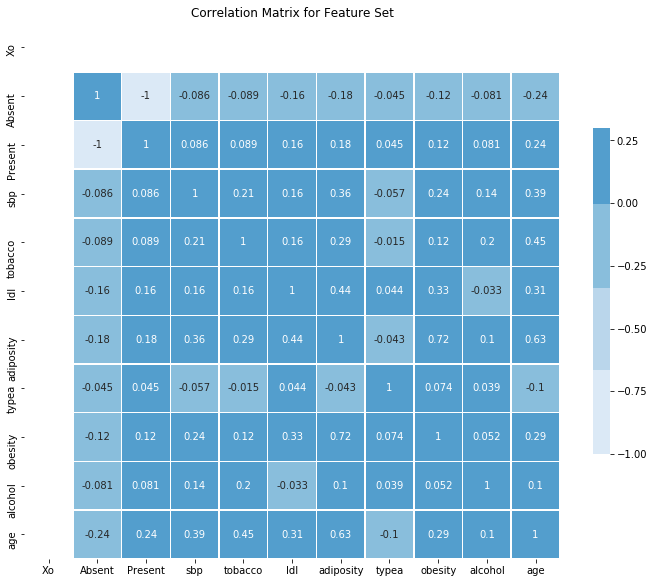

In [13]:
correlation_matrix(X)

As we can see from the correlation matrix, adiposity and age, adiposity and obesity, and tobacco and age 

## Defining Our Functions 

Now we will begin to define our functions for performing our logistic regression on the dataset that we have modified. To do so we need to define a few functions first.

### Hypothesis Model Definition

We will be defining the sigmoid function or our hypothesis model.

In [0]:
def sigmoid(x, thetas):
    
    z = np.matmul(x, thetas.T)
    
    h  = 1 / (1 + np.exp(-z))    
    
    return h

Next, we will define our cost function. For logisitc regression, the cost function is a little different, when compared to linear regression. It is instead calculated by using the binary cross-entropy loss function for a set of training examples with binary labels. 

### Cost Function Definition 

In [0]:
def calc_cost(h, y):
    
    m = len(h)
    total_cost = 0
    
    cost = np.matmul(y.T, np.log(h)) + np.matmul((1-y).T, np.log(1-h))  #mtmul used for quicker calculations
    cost = -cost / m
    
    return cost

### Batch Gradient Descent Definition 

This function will perform a mini batch gradient descent on all of our mini batches and return our converged weights and costs for our dataset


In [0]:
def batch_grad_descent(x,h, y, theta_old, alpha):
    
    m = len(y)
    
    sigma = np.matmul((np.array(y.T) - np.array(h.T)), np.array(x))
    sigma = sigma*alpha/m
    
    for i in range(0, len(theta_old.T)):
      
        theta_old[0,i] = theta_old[0,i] + sigma[0,i]

    return theta_old

### Batch Size Function ( For Mini Batch Gradient Descent) 

In [0]:
def batches(input, batch_size):
  
    for i in range(0, len(input), batch_size):
      
        yield input[i:i+batch_size]

## Initializing Our Weights 

Now we will begin to initialize our weights randomly with a specific seed at the size of the X features dataframe 

In [0]:
np.random.seed(seed=69)                  #calculating random value for each feature weight
thetaInit = np.random.rand(1,X.shape[1]) # random seed every time

thetaInit = np.array(thetaInit)          #converting the weights into a numpy array 
theta = thetaInit.copy()



## Performing Iterative  Batch Gradient Descent 


Firstly, we will perform a regular batch gradient descent using the values for alpha and epochs given to produce the necessary graphs for each scenario. 

In [19]:
X = np.array(X) # avoids dataframe overhead
y = np.array(y) # avoids dataframe overhead

epochs = [500, 1000, 10000]

max_epochs = max(epochs)

cost1 = [0]*max_epochs               #initializing the cost array for alpha = 0.001
thetas = thetaInit.copy()

print('Starting Batch Epochs for alpha = 0.001...\n')

for i in range(0,max_epochs):
            
            h = sigmoid(X,thetas)
            cost1[i] = calc_cost(h, y)
            thetas = batch_grad_descent(X, h, y, thetas, 0.001)
            
            if i % 1000 == 0:
                print(i,"epochs finished\t" + 'cost:' + str(cost1[i]))

cost2 = [0]*max_epochs              #initializing the cost array for alpha = 0.0001
thetas = thetaInit.copy()

print('\n')
print('Starting Batch Epochs for alpha = 0.0001...\n')

for i in range(0,max_epochs):
        
            h = sigmoid(X,thetas)
            cost2[i] = calc_cost(h, y)
            thetas = batch_grad_descent(X, h, y, thetas, 0.0001)
            
            if i % 1000 == 0:
                print(i,"epochs finished\t" + 'cost:' + str(cost2[i]))
        
   

Starting Batch Epochs for alpha = 0.001...

0 epochs finished	cost:[0.99591822]
1000 epochs finished	cost:[0.83600517]
2000 epochs finished	cost:[0.72105862]
3000 epochs finished	cost:[0.64476839]
4000 epochs finished	cost:[0.59727348]
5000 epochs finished	cost:[0.56862803]
6000 epochs finished	cost:[0.55128631]
7000 epochs finished	cost:[0.54045968]
8000 epochs finished	cost:[0.53338902]
9000 epochs finished	cost:[0.52854456]


Starting Batch Epochs for alpha = 0.0001...

0 epochs finished	cost:[0.99591822]
1000 epochs finished	cost:[0.97783154]
2000 epochs finished	cost:[0.96021127]
3000 epochs finished	cost:[0.94305803]
4000 epochs finished	cost:[0.92637198]
5000 epochs finished	cost:[0.91015282]
6000 epochs finished	cost:[0.89439973]
7000 epochs finished	cost:[0.8791114]
8000 epochs finished	cost:[0.864286]
9000 epochs finished	cost:[0.84992113]


Next, we will plot the graph for each cost that was found from the cell above (a total of 6 charts)

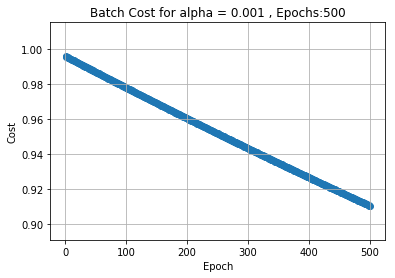

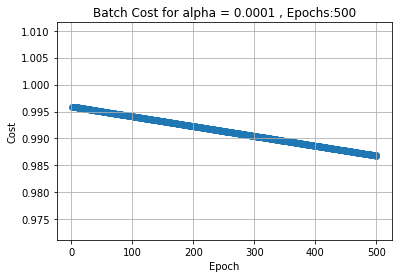

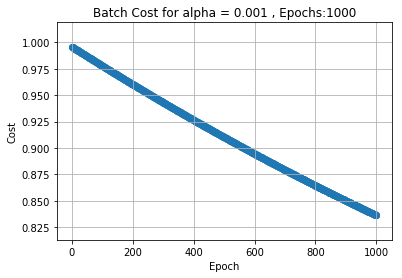

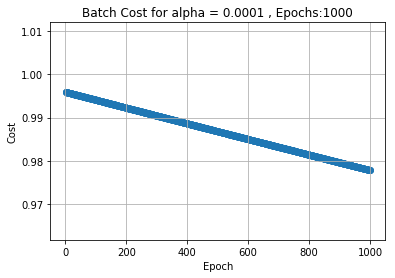

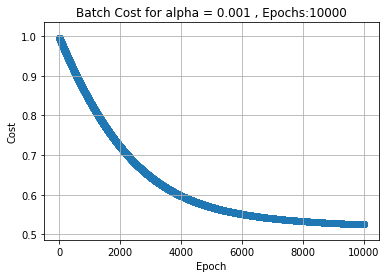

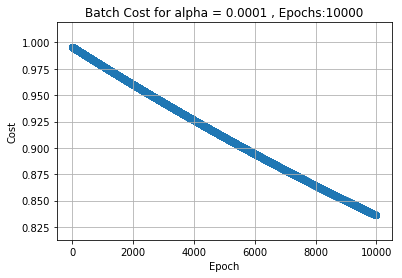

In [20]:
for epoch in epochs:
  
    plt.scatter(np.linspace(1,epoch,epoch), cost1[0:epoch])
    
    plt.title('Batch Cost for alpha = 0.001 , Epochs:' + str(epoch))
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.grid()
    plt.show()
    
    plt.scatter(np.linspace(1,epoch,epoch), cost2[0:epoch])
    
    plt.title('Batch Cost for alpha = 0.0001 , Epochs:' + str(epoch))
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.grid()
    plt.show()

From these charts, we can tell that the learning rate of 0.0001 does not undergo enough iterations to converge to the minimum cost, while the learning rate of 0.001 onverges somwhere close to a cost of 0.51-0.52.

Therefore we can say that is reasonable that we cannot stop at 10,000 epochs for a learning rate of 0.0001 and we can stop at around 10,000 epochs for a learning rate of 0.001

## Performing Iterative Mini Batch Gradient Descent 

*Now* that we have initialized all of our thetas (weights) for all of our features in the dataset, we can begin to perform our mini batch gradient descent the find the change is cost as well as the the most optimum values fro our weights. 

For this mini batch gradient descent, we will be using a batch size of 50 samples. Since our complete dataset contains 462 rows of data, our last batch will only contain 12 rows 


In [21]:
X = np.array(X) # avoids dataframe overhead
y = np.array(y) # avoids dataframe overhead

# now we will seperate the feature and output total dataset into their own respective batches
X_batch = list(batches(X,50)) 
y_batch = list(batches(y,50))

batch_total = len(X_batch)           # counting the total number of batches per epoch 

max_epochs = max(epochs)

alphas = [0.0001, 0.001]
epochs = [500, 1000, 10000]

cost1_mini = [0]*max_epochs          #initializing the cost array for each mini-batch
batch_cost1 = [0]*batch_total        #initialzing the cost array for the total cost from each epoch 
thetas = thetaInit.copy()

print('Starting Mini-Batch Epochs for alpha = 0.001...\n')

for i in range(0,max_epochs):
  
    for k in range(0,batch_total):
            
            h = sigmoid(X_batch[k],thetas)
            batch_cost1[k] = calc_cost(h,y_batch[k])
            thetas = batch_grad_descent(X_batch[k], h, y_batch[k], thetas, 0.001)
            
    cost1_mini[i] = sum(batch_cost1)/batch_total
    
    if i % 1000 == 0:
         print(i,"epochs finished\t" + 'cost:' + str(cost1_mini[i]))

theta_final = thetas.copy()

cost2_mini = [0]*max_epochs         #initializing the cost array for each mini-batch
batch_cost2 = [0]*batch_total       #initialzing the cost array for the total cost from each epoch
thetas = thetaInit.copy()

print('\n')
print('Starting Mini-Batch Epochs for alpha = 0.0001...\n')

for i in range(0,max_epochs):
  
    for k in range(0,batch_total):
            
            h = sigmoid(X_batch[k],thetas)
            batch_cost2[k] = calc_cost(h,y_batch[k])
            thetas = batch_grad_descent(X_batch[k], h, y_batch[k], thetas, 0.0001)
            
    cost2_mini[i] = sum(batch_cost2)/batch_total
    
    if i % 1000 == 0:
         print(i,"epochs finished\t" + 'cost:' + str(cost2_mini[i]))


Starting Mini-Batch Epochs for alpha = 0.001...

0 epochs finished	cost:[1.02060248]
1000 epochs finished	cost:[0.54885306]
2000 epochs finished	cost:[0.53705052]
3000 epochs finished	cost:[0.53471296]
4000 epochs finished	cost:[0.53388874]
5000 epochs finished	cost:[0.53351135]
6000 epochs finished	cost:[0.53332026]
7000 epochs finished	cost:[0.53322014]
8000 epochs finished	cost:[0.53316702]
9000 epochs finished	cost:[0.53313867]


Starting Mini-Batch Epochs for alpha = 0.0001...

0 epochs finished	cost:[1.02131677]
1000 epochs finished	cost:[0.85945078]
2000 epochs finished	cost:[0.74346355]
3000 epochs finished	cost:[0.6671593]
4000 epochs finished	cost:[0.62013626]
5000 epochs finished	cost:[0.59196229]
6000 epochs finished	cost:[0.57492151]
7000 epochs finished	cost:[0.56423954]
8000 epochs finished	cost:[0.5572135]
9000 epochs finished	cost:[0.55235816]


Next, we will plot the graph for each cost that was found from the cell above (a total of 6 charts)

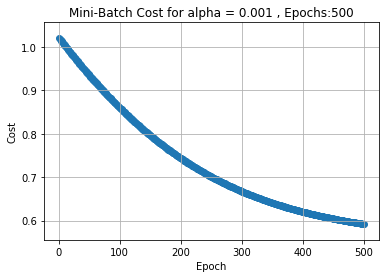

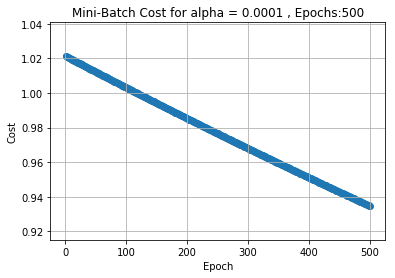

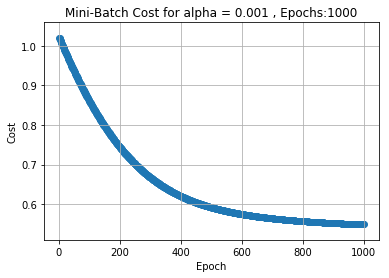

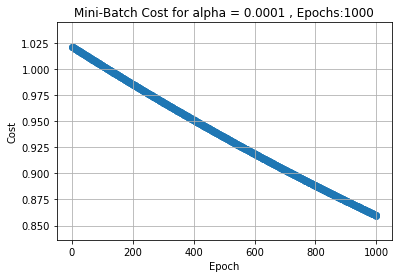

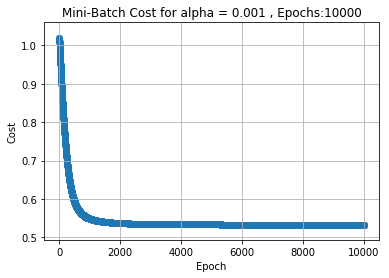

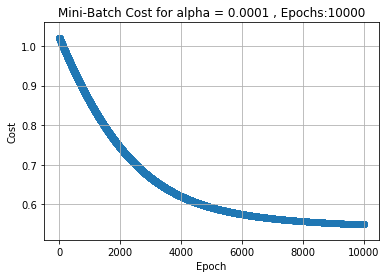

In [22]:
for epoch in epochs:
  
    plt.scatter(np.linspace(1,epoch,epoch), cost1_mini[0:epoch])
    
    plt.title('Mini-Batch Cost for alpha = 0.001 , Epochs:' + str(epoch))
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.grid()
    plt.show()
    
    plt.scatter(np.linspace(1,epoch,epoch), cost2_mini[0:epoch])
    
    plt.title('Mini-Batch Cost for alpha = 0.0001 , Epochs:' + str(epoch))
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.grid()
    plt.show()

From these charts, we can tell that once again, the learning rate of 0.0001 does not undergo enough iterations to converge to a minimum cost, while the learning rate of 0.001 onverges somwhere close to a cost of 0.51-0.52.

Therefore we can say that is reasonable that we cannot stop at 10,000 epochs for a learning rate of 0.0001 and we can stop at around 2,000 epochs for a learning rate of 0.001

## Validating Our Model Using Sci-Kit Learn's LogisticRegression 

Now that we've obtained out results it is time to test out how accurate they actually are. To do this, we will compare our results to he ones given by the sci-kit learn LogisticRegression function using the fit() object. Below we can see our results.

In [0]:
import warnings
warnings.filterwarnings("ignore") # suppressing sklearn warnings for Sci-kit learn's solver 

In [0]:
logisticRegr = LogisticRegression()  #performing logistic regression 

In [25]:
logisticRegr.fit(X, y)               #fitting the model 

print ('The Sci-Kit Learn Logistic Regression weights are: \n')
print ('theta 0 = ' + str(logisticRegr.coef_[0][0]))
print ('theta 1 = ' + str(logisticRegr.coef_[0][1]))
print ('theta 2 = ' + str(logisticRegr.coef_[0][2]))
print ('theta 3 = ' + str(logisticRegr.coef_[0][3]))
print ('theta 4 = ' + str(logisticRegr.coef_[0][4]))
print ('theta 5 = ' + str(logisticRegr.coef_[0][5]))
print ('theta 6 = ' + str(logisticRegr.coef_[0][6]))
print ('theta 7 = ' + str(logisticRegr.coef_[0][7]))
print ('theta 8 = ' + str(logisticRegr.coef_[0][8]))
print ('theta 9 = ' + str(logisticRegr.coef_[0][9]))
print ('theta 10 = ' + str(logisticRegr.coef_[0][10]))

The Sci-Kit Learn Logistic Regression weights are: 

theta 0 = -0.3163818182532838
theta 1 = -0.6096602360642907
theta 2 = 0.29327841781101577
theta 3 = 0.13304861516866623
theta 4 = 0.36174850063654485
theta 5 = 0.35522970875919474
theta 6 = 0.14254346879992108
theta 7 = 0.37916715523075906
theta 8 = -0.255769023944752
theta 9 = 0.0034036744779752945
theta 10 = 0.6465651604992869


In [32]:
print('The final wieghts calucated by our mini-batch gradient descent are: \n')
print ('thetas= ' + str(theta_final[0]))
print('\n')
print ('theta 1 = ' + str(theta_final[0][0]))
print ('theta 2 = ' + str(theta_final[0][1]))
print ('theta 3 = ' + str(theta_final[0][2]))
print ('theta 4 = ' + str(theta_final[0][3]))
print ('theta 5 = ' + str(theta_final[0][4]))
print ('theta 6 = ' + str(theta_final[0][6]))
print ('theta 7 = ' + str(theta_final[0][7]))
print ('theta 8 = ' + str(theta_final[0][8]))
print ('theta 9 = ' + str(theta_final[0][9]))
print ('theta 10 = ' + str(theta_final[0][10]))

The final wieghts calucated by our mini-batch gradient descent are: 

thetas= [-0.7800286  -0.38025107  0.46329355  0.07835026  0.34240807  0.28986055
  0.34499696  0.27417668 -0.36477394  0.01309635  0.5141401 ]


theta 1 = -0.7800286010047379
theta 2 = -0.3802510731542737
theta 3 = 0.46329355137385586
theta 4 = 0.07835026212126954
theta 5 = 0.34240806724150225
theta 6 = 0.3449969621149868
theta 7 = 0.2741766843631624
theta 8 = -0.36477394448410405
theta 9 = 0.013096346881632403
theta 10 = 0.5141400954051177


As we can see, there are some values with little difference between the logisitc regression and our gradient descent, and there are other coefficients (eg. theta 0) have a larger, double-digit differences

This could  be explained by the scikit-learn algorithm either performing a muc fewer number of iterations, resulting in  different local minima for the cost function,. Another potential result for the difference is using a different method of coefficient approximation other than gradient descent. It is possible that the logistic regression toolbox utilizes Newton's method rather than regular gradient descent or mini-batch gradient descent. 

##Conclusion

Overall, this lab taught us that we can successfully implement a method of performing logistic regression using the gradient descent algorithm to predict feature weights of a particular dataset.

To overcome the total overhead from using a dataframe to perform all te calculations necessary., it is important to convert the dataset into mathematical array, that allow us to perofrm calculations using the numpy library alot quicker, thus improving the performance and effeciency of this algorithm tremendously. 

